In [1]:
#  Imports
from src.parsers import HMParser
from src.resources import BinaryResource, Generator, Load, Storage, Vehicle
from src.scenes import HMProblemScene
import build_data
from build_data import ext_pyomo_vals
import numpy as np
import matplotlib.pyplot as plt
import copy

# Ignore the warnings (only demonstration purposes!)
import warnings
warnings.filterwarnings("ignore")

In [2]:
project_colors = {"green": "#58c1ae", "blue": "#0e73b9", "lightgreen": "#cdd451",
                  "babyblue": "#5ebcea", "orange": "#e58033", "yellow": "#eacf5e",
                  "raw": "#ece9d6"}
project_colors_list = ["#58c1ae", "#0e73b9", "#cdd451", "#5ebcea", "#e58033","#eacf5e","#ece9d6"] 

### Defining set up variables, important to get the data from mysql db.

In [3]:
# Set up variables 

_specific_date='2019-11-06' # -> Change date
_time_step = 60 # -> Change time step
_update_forecast = False # -> True to have forecast updat in the operation
_save_plots = True # -> True to save the plots

#Comentarios sobre performance de dias
#Dia 6 corre rapido
#ao fim do dia 13 as previsões sao maiores do q o consumo real
#dia 16/17 é um exemplo de uma pessima previsão

# Method 1 - Forecast Data:

In this method, it is used the data from mysql forecast databases as input for load and generators.

In [4]:
# Data parsing
method_obj_1 = build_data.Data(_file_path='data/EC_V4_new_UC2.xlsx', ec_id=1) 

In [5]:
method_obj_1.data.storage.keys()

dict_keys(['p_charge_limit', 'p_discharge_limit', 'charge_price', 'discharge_price', 'internal_bus_location', 'battery_type', 'owner', 'manager', 'type_contract', 'energy_capacity', 'energy_min_percentage', 'charge_efficiency', 'discharge_efficiency', 'initial_state', 'p_charge_max', 'p_discharge_max'])

In [6]:
method1_folder = "./input_data/method1"

# Define generators
gens = Generator(name='gens',
                 value=np.zeros(method_obj_1.data.generator['p_forecast'].shape),
                 lower_bound=np.zeros(method_obj_1.data.generator['p_forecast'].shape),
                 upper_bound=method_obj_1.data.generator['p_forecast'],
                 cost=method_obj_1.data.generator['cost_parameter_b'],
                 cost_nde=method_obj_1.data.generator['cost_nde'],
                 is_renewable=method_obj_1.data.generator['type_generator'])

method_obj_1.get_data_from_db(specific_date=_specific_date, table="generators_forecast", end = 24*60//_time_step, experiment_id = 17, time_step=_time_step, folder=method1_folder, save=True)


# Define loads
loads = Load(name='loads',
             value=method_obj_1.data.load['p_forecast'],
             lower_bound=np.zeros(method_obj_1.data.load['p_forecast'].shape),
             upper_bound=method_obj_1.data.load['p_forecast'],
             cost=np.ones(method_obj_1.data.load['p_forecast'].shape),
             cost_cut=method_obj_1.data.load['cost_cut'],
             cost_reduce=method_obj_1.data.load['cost_reduce'],
             cost_ens=method_obj_1.data.load['cost_ens'])


method_obj_1.get_data_from_db(specific_date=_specific_date, table="loads_forecast", end = 24*60//_time_step, experiment_id = 23, time_step=_time_step, folder=method1_folder, save=True)

# Define storage
stor = Storage(name='stor',
               value=np.zeros(method_obj_1.data.storage['p_charge_limit'].shape),
               lower_bound=np.zeros(method_obj_1.data.storage['p_charge_limit'].shape),
               upper_bound=(method_obj_1.data.storage['energy_capacity'] *
                            np.ones(method_obj_1.data.storage['p_charge_limit'].shape).transpose()).transpose(),
               cost=np.ones(method_obj_1.data.storage['p_charge_limit'].shape),
               cost_discharge=method_obj_1.data.storage['discharge_price'],
               cost_charge=method_obj_1.data.storage['charge_price'],
               capacity_max=method_obj_1.data.storage['energy_capacity'],
               capacity_min=method_obj_1.data.storage['energy_min_percentage'],
               initial_charge=method_obj_1.data.storage['initial_state'],
               discharge_efficiency=method_obj_1.data.storage['discharge_efficiency'],
               discharge_max=method_obj_1.data.storage['p_discharge_limit'],
               charge_efficiency=method_obj_1.data.storage['charge_efficiency'],
               charge_max=method_obj_1.data.storage['p_charge_limit'],
               #capital_cost=np.tile(np.array([0.05250, 0.10500, 0.01575]), 10))
               #@TODO Coloquei array tamanho 4 no capital cost pois há 4 css
               capital_cost=np.array([0.05250, 0.10500, 0.01575, 0.01575]))
stor.to_json(path=method1_folder)

# Define vehicle to grid
v2g = Vehicle(name='evs',
              value=np.zeros(method_obj_1.data.vehicle['schedule_charge'].shape),
              lower_bound=(method_obj_1.data.vehicle['e_capacity_max'] * method_obj_1.data.vehicle['min_technical_soc'] *
                           np.ones(method_obj_1.data.vehicle['schedule_charge'].shape).transpose()).transpose(),
              upper_bound=(method_obj_1.data.vehicle['e_capacity_max'] * np.ones(method_obj_1.data.vehicle['schedule_charge'].shape).transpose()).transpose(),
              cost=np.ones(method_obj_1.data.vehicle['schedule_charge'].shape),
              cost_discharge=method_obj_1.data.vehicle['discharge_price'][:, 0],
              cost_charge=method_obj_1.data.vehicle['charge_price'][:, 0],
              capacity_max=method_obj_1.data.vehicle['e_capacity_max'],
              initial_charge=np.ones(method_obj_1.data.vehicle['schedule_charge'].shape) * 0.8,
              min_charge=method_obj_1.data.vehicle['min_technical_soc'],
              discharge_efficiency=method_obj_1.data.vehicle['discharge_efficiency'],
              charge_efficiency=method_obj_1.data.vehicle['charge_efficiency'],
              #capital_cost=np.tile(np.array([0.042, 0.063, 0.042, 0.042, 0.063]), 10),
              #@TODO Coloquei array tamanho 7 no capital cost pois há 7 carros
              capital_cost=np.array([0.042, 0.063, 0.042, 0.042, 0.063, 0.063, 0.063]), 
              schedule_discharge=method_obj_1.data.vehicle['schedule_discharge'],
              schedule_charge=method_obj_1.data.vehicle['schedule_charge'])
v2g.to_json(path=method1_folder)

# Define imports and exports
pimp = BinaryResource(name='pImp',
                      value=np.zeros(method_obj_1.data.peers['import_contracted_p_max'][0, :].shape),
                      lower_bound=np.zeros(method_obj_1.data.peers['import_contracted_p_max'][0, :].shape),
                      upper_bound=method_obj_1.data.peers['import_contracted_p_max'][0, :],
                      cost=method_obj_1.data.peers['buy_price'][0, :],
                      is_active=np.zeros(method_obj_1.data.peers['import_contracted_p_max'][0, :].shape))
pimp.to_json(path=method1_folder)

pexp = BinaryResource(name='pExp',
                      value=np.zeros(method_obj_1.data.peers['export_contracted_p_max'][0, :].shape),
                      lower_bound=np.zeros(method_obj_1.data.peers['export_contracted_p_max'][0, :].shape),
                      upper_bound=method_obj_1.data.peers['export_contracted_p_max'][0, :],
                      cost=method_obj_1.data.peers['sell_price'][0, :],
                      is_active=np.zeros(method_obj_1.data.peers['export_contracted_p_max'][0, :].shape))
pexp.to_json(path=method1_folder)

# Establish the components
ec_components = {'gen': gens,
                 'loads': loads,
                 'stor': stor,
                 'evs': v2g,
                 'pimp': pimp,
                 'pexp': pexp}

ec_components

{'gen': gens,
 'loads': loads,
 'stor': stor,
 'evs': evs,
 'pimp': pImp,
 'pexp': pExp}

In [7]:
# Create the scene

scene = HMProblemScene(name='EC1', data=ec_components, hm_parser=method_obj_1.data, pop_size=20,
                       n_iter=10000, iter_tolerance=1000)
scene.initialize()
scene.run()

 79%|███████▊  | 7872/10000 [21:48<05:53,  6.02it/s]   


KeyboardInterrupt: 

In [ ]:
scene.to_json(path="./results/method_1", filename="scene1_results")

In [ ]:
scene.current_best.keys()

dict_keys(['genActPower', 'genExcActPower', 'pImp', 'pExp', 'loadRedActPower', 'loadCutActPower', 'loadENS', 'storDchActPower', 'storChActPower', 'EminRelaxStor', 'storEnerState', 'v2gDchActPower', 'v2gChActPower', 'EminRelaxEV', 'v2gEnerState', 'genXo', 'loadXo', 'storDchXo', 'storChXo', 'v2gDchXo', 'v2gChXo'])

In [ ]:
scene.exporting_results()

In [ ]:
scene.export_profile_to_excel(scene.current_best['genActPower'], scene.current_best['storDchActPower'],
                              scene.current_best['v2gDchActPower'], scene.current_best['loadRedActPower'],
                              scene.current_best['loadCutActPower'], scene.current_best['loadENS'],
                              scene.current_best['pImp'], scene.current_best['genExcActPower'],
                              scene.current_best['storChActPower'], scene.current_best['v2gChActPower'],
                              loads.value,
                              name="profile_data_1.xlsx", path="results/method_1"
                              )

Opaaaa 5


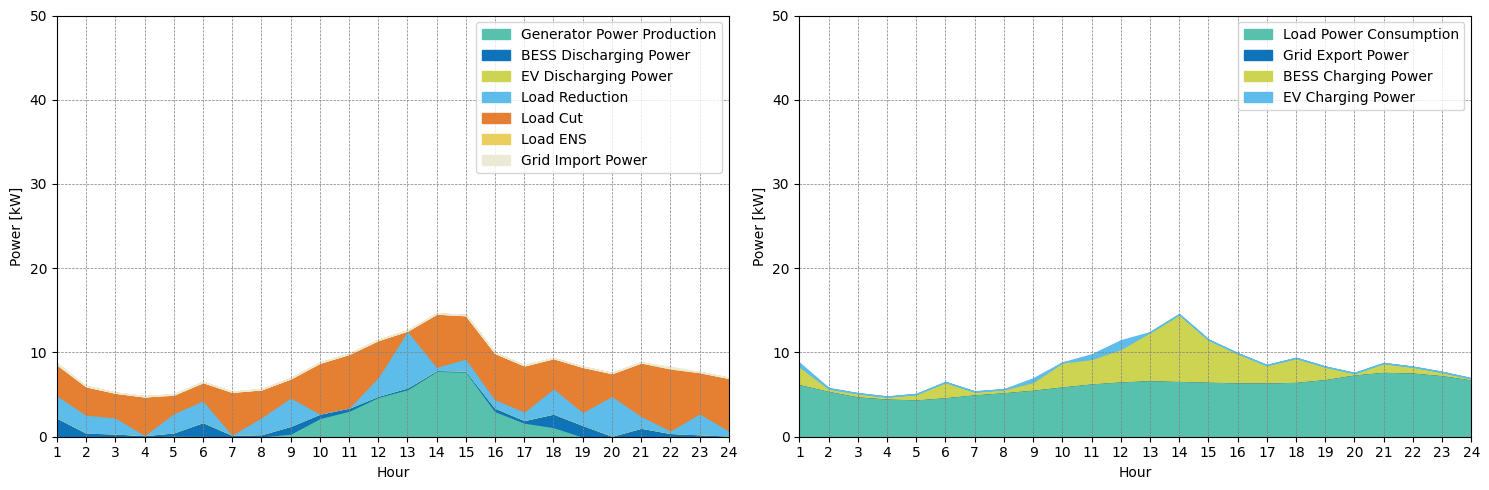

In [ ]:
scene.plot(scene.current_best['genActPower'], scene.current_best['storDchActPower'],
                              scene.current_best['v2gDchActPower'], scene.current_best['loadRedActPower'],
                              scene.current_best['loadCutActPower'], scene.current_best['loadENS'],
                              scene.current_best['pImp'], scene.current_best['genExcActPower'],
                              scene.current_best['storChActPower'], scene.current_best['v2gChActPower'],
                              loads.value,
                              name="profile_data_1", path="plots/method_1", graph_max=40, graph_step=10)

In [ ]:
#scene.components['evs'].capital_cost
v2g.cost_discharge

array([0.05, 0.06, 0.05, 0.05, 0.06, 0.06, 0.06], dtype=object)

In [ ]:
# Sum matrices along the columns

scene.algo.population_fitness

[89.84839190904609,
 89.88783676760923,
 89.95073862404716,
 89.92618243493148,
 89.83348616004125,
 89.85460766606049,
 89.86154239211903,
 89.8355711841631,
 89.88914723663542,
 89.86307886628568,
 89.84579207485044,
 89.82708750496845,
 89.8772139982114,
 89.82486811287504,
 89.83163805351124,
 89.8286557661606,
 89.87232724891763,
 89.84130297514002,
 89.87564519201719,
 89.86829040482874]

In [ ]:
 # Check the population

scene.algo.population

array([[0.01270559, 0.01152178, 0.00143169, ..., 0.        , 1.        ,
        1.        ],
       [0.01199345, 0.01146637, 0.00125678, ..., 0.        , 1.        ,
        1.        ],
       [0.01408358, 0.01146982, 0.00164533, ..., 0.        , 1.        ,
        1.        ],
       ...,
       [0.0139979 , 0.01147545, 0.00140676, ..., 0.        , 1.        ,
        1.        ],
       [0.01405679, 0.01157752, 0.00163515, ..., 0.        , 1.        ,
        1.        ],
       [0.01323841, 0.01136839, 0.00122598, ..., 0.        , 1.        ,
        1.        ]])

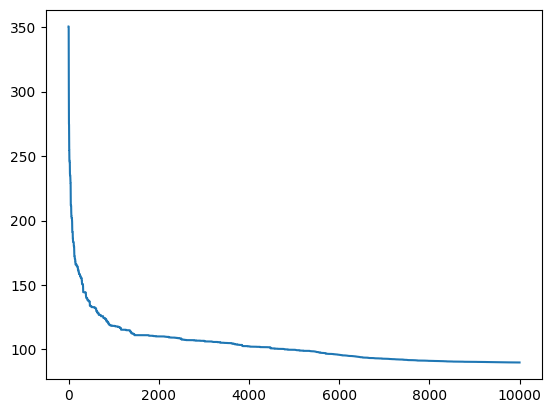

In [ ]:
plt.plot(scene.algo.population_history_fitness)

In [ ]:
scene.algo.population_history_fitness

[350.5893614833066,
 350.5893614833066,
 306.37844620569234,
 306.37844620569234,
 305.28865728382664,
 284.64304753361716,
 284.64304753361716,
 274.92913310337474,
 274.7014053047432,
 274.4048814006523,
 261.9268595335309,
 261.9268595335309,
 261.9268595335309,
 254.6876255801422,
 254.6876255801422,
 248.92852065917072,
 248.62047525541246,
 246.44435088913815,
 246.44435088913815,
 246.44435088913815,
 246.44435088913815,
 246.44435088913815,
 244.90639367289634,
 244.90639367289634,
 244.90639367289634,
 244.90639367289634,
 244.90639367289634,
 236.15238590487618,
 236.15238590487618,
 236.15238590487618,
 235.1002175421562,
 235.1002175421562,
 235.1002175421562,
 235.1002175421562,
 235.1002175421562,
 235.1002175421562,
 235.1002175421562,
 233.73307059487902,
 232.62146039981462,
 232.62146039981462,
 229.23631881949487,
 228.903078426805,
 228.903078426805,
 228.903078426805,
 228.903078426805,
 221.80762700004055,
 221.80762700004055,
 211.61277361922663,
 211.61277361922

In [ ]:
scene.algo.population_fitness

[89.84839190904609,
 89.88783676760923,
 89.95073862404716,
 89.92618243493148,
 89.83348616004125,
 89.85460766606049,
 89.86154239211903,
 89.8355711841631,
 89.88914723663542,
 89.86307886628568,
 89.84579207485044,
 89.82708750496845,
 89.8772139982114,
 89.82486811287504,
 89.83163805351124,
 89.8286557661606,
 89.87232724891763,
 89.84130297514002,
 89.87564519201719,
 89.86829040482874]

In [ ]:
scene.current_best_fitness

89.82486811287504

# Method 2 - Real Data

In [ ]:
# Data parsing
method_obj_2 = build_data.Data(_file_path='data/EC_V4_new_UC2.xlsx', ec_id=1) 

In [ ]:
method_obj_2.data.storage.keys()

In [ ]:
method2_folder = "./input_data/method2"

# Define generators
gens = Generator(name='gens',
                 value=np.zeros(method_obj_2.data.generator['p_forecast'].shape),
                 lower_bound=np.zeros(method_obj_2.data.generator['p_forecast'].shape),
                 upper_bound=method_obj_2.data.generator['p_forecast'],
                 cost=method_obj_2.data.generator['cost_parameter_b'],
                 cost_nde=method_obj_2.data.generator['cost_nde'],
                 is_renewable=method_obj_2.data.generator['type_generator'])

method_obj_2.get_data_from_db(specific_date=_specific_date, table="generators", end = 24*60//_time_step, 
                             time_step=_time_step, folder=method2_folder, save=True)


# Define loads
loads = Load(name='loads',
             value=method_obj_2.data.load['p_forecast'],
             lower_bound=np.zeros(method_obj_2.data.load['p_forecast'].shape),
             upper_bound=method_obj_2.data.load['p_forecast'],
             cost=np.ones(method_obj_2.data.load['p_forecast'].shape),
             cost_cut=method_obj_2.data.load['cost_cut'],
             cost_reduce=method_obj_2.data.load['cost_reduce'],
             cost_ens=method_obj_2.data.load['cost_ens'])


method_obj_2.get_data_from_db(specific_date=_specific_date, table="loads", end = 24*60//_time_step, 
                            time_step=_time_step, folder=method2_folder, save=True)

# Define storage
stor = Storage(name='stor',
               value=np.zeros(method_obj_2.data.storage['p_charge_limit'].shape),
               lower_bound=np.zeros(method_obj_2.data.storage['p_charge_limit'].shape),
               upper_bound=(method_obj_2.data.storage['energy_capacity'] *
                            np.ones(method_obj_2.data.storage['p_charge_limit'].shape).transpose()).transpose(),
               cost=np.ones(method_obj_2.data.storage['p_charge_limit'].shape),
               cost_discharge=method_obj_2.data.storage['discharge_price'],
               cost_charge=method_obj_2.data.storage['charge_price'],
               capacity_max=method_obj_2.data.storage['energy_capacity'],
               capacity_min=method_obj_2.data.storage['energy_min_percentage'],
               initial_charge=method_obj_2.data.storage['initial_state'],
               discharge_efficiency=method_obj_2.data.storage['discharge_efficiency'],
               discharge_max=method_obj_2.data.storage['p_discharge_limit'],
               charge_efficiency=method_obj_2.data.storage['charge_efficiency'],
               charge_max=method_obj_2.data.storage['p_charge_limit'],
               #capital_cost=np.tile(np.array([0.05250, 0.10500, 0.01575]), 10))
               #@TODO Coloquei array tamanho 4 no capital cost pois há 4 css
               capital_cost=np.array([0.05250, 0.10500, 0.01575, 0.01575]))
stor.to_json(path=method2_folder)

# Define vehicle to grid
v2g = Vehicle(name='evs',
              value=np.zeros(method_obj_2.data.vehicle['schedule_charge'].shape),
              lower_bound=(method_obj_2.data.vehicle['e_capacity_max'] * method_obj_2.data.vehicle['min_technical_soc'] *
                           np.ones(method_obj_2.data.vehicle['schedule_charge'].shape).transpose()).transpose(),
              upper_bound=(method_obj_2.data.vehicle['e_capacity_max'] * np.ones(method_obj_2.data.vehicle['schedule_charge'].shape).transpose()).transpose(),
              cost=np.ones(method_obj_2.data.vehicle['schedule_charge'].shape),
              cost_discharge=method_obj_2.data.vehicle['discharge_price'][:, 0],
              cost_charge=method_obj_2.data.vehicle['charge_price'][:, 0],
              capacity_max=method_obj_2.data.vehicle['e_capacity_max'],
              initial_charge=np.ones(method_obj_2.data.vehicle['schedule_charge'].shape) * 0.8,
              min_charge=method_obj_2.data.vehicle['min_technical_soc'],
              discharge_efficiency=method_obj_2.data.vehicle['discharge_efficiency'],
              charge_efficiency=method_obj_2.data.vehicle['charge_efficiency'],
              #capital_cost=np.tile(np.array([0.042, 0.063, 0.042, 0.042, 0.063]), 10),
              #@TODO Coloquei array tamanho 7 no capital cost pois há 7 carros
              capital_cost=np.array([0.042, 0.063, 0.042, 0.042, 0.063, 0.063, 0.063]), 
              schedule_discharge=method_obj_2.data.vehicle['schedule_discharge'],
              schedule_charge=method_obj_2.data.vehicle['schedule_charge'])
v2g.to_json(path=method2_folder)

# Define imports and exports
pimp = BinaryResource(name='pImp',
                      value=np.zeros(method_obj_2.data.peers['import_contracted_p_max'][0, :].shape),
                      lower_bound=np.zeros(method_obj_2.data.peers['import_contracted_p_max'][0, :].shape),
                      upper_bound=method_obj_2.data.peers['import_contracted_p_max'][0, :],
                      cost=method_obj_2.data.peers['buy_price'][0, :],
                      is_active=np.zeros(method_obj_2.data.peers['import_contracted_p_max'][0, :].shape))
pimp.to_json(path=method2_folder)

pexp = BinaryResource(name='pExp',
                      value=np.zeros(method_obj_2.data.peers['export_contracted_p_max'][0, :].shape),
                      lower_bound=np.zeros(method_obj_2.data.peers['export_contracted_p_max'][0, :].shape),
                      upper_bound=method_obj_2.data.peers['export_contracted_p_max'][0, :],
                      cost=method_obj_2.data.peers['sell_price'][0, :],
                      is_active=np.zeros(method_obj_2.data.peers['export_contracted_p_max'][0, :].shape))
pexp.to_json(path=method2_folder)

# Establish the components
ec_components = {'gen': gens,
                 'loads': loads,
                 'stor': stor,
                 'evs': v2g,
                 'pimp': pimp,
                 'pexp': pexp}

ec_components

In [ ]:
# Create the scene

scene2 = HMProblemScene(name='EC2', data=ec_components, hm_parser=method_obj_2.data, pop_size=20,
                       n_iter=10000, iter_tolerance=1000)
scene2.initialize()
scene2.run()

In [ ]:
scene2.to_json(path="./results/method_2", filename="scene2_results")

In [ ]:
scene2.current_best.keys()

In [ ]:
scene2.exporting_results()

In [ ]:
scene2.export_profile_to_excel(scene.current_best['genActPower'], scene.current_best['storDchActPower'],
                              scene.current_best['v2gDchActPower'], scene.current_best['loadRedActPower'],
                              scene.current_best['loadCutActPower'], scene.current_best['loadENS'],
                              scene.current_best['pImp'], scene.current_best['genExcActPower'],
                              scene.current_best['storChActPower'], scene.current_best['v2gChActPower'],
                              loads.value,
                              name="profile_data_2.xlsx", path="results/method_2"
                              )

In [ ]:
scene2.plot(scene.current_best['genActPower'], scene.current_best['storDchActPower'],
                              scene.current_best['v2gDchActPower'], scene.current_best['loadRedActPower'],
                              scene.current_best['loadCutActPower'], scene.current_best['loadENS'],
                              scene.current_best['pImp'], scene.current_best['genExcActPower'],
                              scene.current_best['storChActPower'], scene.current_best['v2gChActPower'],
                              loads.value,
                              name="profile_data_2", path="plots/method_2", graph_max=40, graph_step=10)

In [ ]:
#scene.components['evs'].capital_cost
v2g.cost_discharge

In [ ]:
# Sum matrices along the columns

scene2.algo.population_fitness

In [ ]:
 # Check the population

scene2.algo.population

In [ ]:
plt.plot(scene2.algo.population_history_fitness)

In [ ]:
scene2.algo.population_history_fitness

In [ ]:
scene2.algo.population_fitness

In [ ]:
scene2.current_best_fitness

# Method 3 - Forecast + Real Data

In [ ]:
# Data parsing
method_obj_3 = build_data.Data(_file_path='data/EC_V4_new_UC2.xlsx', ec_id=1) 

In [ ]:
method_obj_3.data.storage.keys()

In [ ]:
method3_folder = "./input_data/method3"

# Define generators
gens = Generator(name='gens',
                 value=np.zeros(method_obj_3.data.generator['p_forecast'].shape),
                 lower_bound=np.zeros(method_obj_3.data.generator['p_forecast'].shape),
                 upper_bound=method_obj_3.data.generator['p_forecast'],
                 cost=method_obj_3.data.generator['cost_parameter_b'],
                 cost_nde=method_obj_3.data.generator['cost_nde'],
                 is_renewable=method_obj_3.data.generator['type_generator'])

method_obj_3.get_data_from_db(specific_date=_specific_date, table="generators", end = 24*60//_time_step, 
                             time_step=_time_step, folder=method3_folder, save=True)


# Define loads
loads = Load(name='loads',
             value=method_obj_3.data.load['p_forecast'],
             lower_bound=np.zeros(method_obj_3.data.load['p_forecast'].shape),
             upper_bound=method_obj_3.data.load['p_forecast'],
             cost=np.ones(method_obj_3.data.load['p_forecast'].shape),
             cost_cut=method_obj_3.data.load['cost_cut'],
             cost_reduce=method_obj_3.data.load['cost_reduce'],
             cost_ens=method_obj_3.data.load['cost_ens'])


method_obj_3.get_data_from_db(specific_date=_specific_date, table="loads", end = 24*60//_time_step, 
                            time_step=_time_step, folder=method2_folder, save=True)

# Define storage
stor = Storage(name='stor',
               value=np.zeros(method_obj_3.data.storage['p_charge_limit'].shape),
               lower_bound=np.zeros(method_obj_3.data.storage['p_charge_limit'].shape),
               upper_bound=(method_obj_3.data.storage['energy_capacity'] *
                            np.ones(method_obj_3.data.storage['p_charge_limit'].shape).transpose()).transpose(),
               cost=np.ones(method_obj_3.data.storage['p_charge_limit'].shape),
               cost_discharge=method_obj_3.data.storage['discharge_price'],
               cost_charge=method_obj_3.data.storage['charge_price'],
               capacity_max=method_obj_3.data.storage['energy_capacity'],
               capacity_min=method_obj_3.data.storage['energy_min_percentage'],
               initial_charge=method_obj_3.data.storage['initial_state'],
               discharge_efficiency=method_obj_3.data.storage['discharge_efficiency'],
               discharge_max=method_obj_3.data.storage['p_discharge_limit'],
               charge_efficiency=method_obj_3.data.storage['charge_efficiency'],
               charge_max=method_obj_3.data.storage['p_charge_limit'],
               #capital_cost=np.tile(np.array([0.05250, 0.10500, 0.01575]), 10))
               #@TODO Coloquei array tamanho 4 no capital cost pois há 4 css
               capital_cost=np.array([0.05250, 0.10500, 0.01575, 0.01575]))
stor.to_json(path=method2_folder)

# Define vehicle to grid
v2g = Vehicle(name='evs',
              value=np.zeros(method_obj_3.data.vehicle['schedule_charge'].shape),
              lower_bound=(method_obj_3.data.vehicle['e_capacity_max'] * method_obj_3.data.vehicle['min_technical_soc'] *
                           np.ones(method_obj_3.data.vehicle['schedule_charge'].shape).transpose()).transpose(),
              upper_bound=(method_obj_3.data.vehicle['e_capacity_max'] * np.ones(method_obj_3.data.vehicle['schedule_charge'].shape).transpose()).transpose(),
              cost=np.ones(method_obj_3.data.vehicle['schedule_charge'].shape),
              cost_discharge=method_obj_3.data.vehicle['discharge_price'][:, 0],
              cost_charge=method_obj_3.data.vehicle['charge_price'][:, 0],
              capacity_max=method_obj_3.data.vehicle['e_capacity_max'],
              initial_charge=np.ones(method_obj_3.data.vehicle['schedule_charge'].shape) * 0.8,
              min_charge=method_obj_3.data.vehicle['min_technical_soc'],
              discharge_efficiency=method_obj_3.data.vehicle['discharge_efficiency'],
              charge_efficiency=method_obj_3.data.vehicle['charge_efficiency'],
              #capital_cost=np.tile(np.array([0.042, 0.063, 0.042, 0.042, 0.063]), 10),
              #@TODO Coloquei array tamanho 7 no capital cost pois há 7 carros
              capital_cost=np.array([0.042, 0.063, 0.042, 0.042, 0.063, 0.063, 0.063]), 
              schedule_discharge=method_obj_3.data.vehicle['schedule_discharge'],
              schedule_charge=method_obj_3.data.vehicle['schedule_charge'])
v2g.to_json(path=method2_folder)

# Define imports and exports
pimp = BinaryResource(name='pImp',
                      value=np.zeros(method_obj_3.data.peers['import_contracted_p_max'][0, :].shape),
                      lower_bound=np.zeros(method_obj_3.data.peers['import_contracted_p_max'][0, :].shape),
                      upper_bound=method_obj_3.data.peers['import_contracted_p_max'][0, :],
                      cost=method_obj_3.data.peers['buy_price'][0, :],
                      is_active=np.zeros(method_obj_3.data.peers['import_contracted_p_max'][0, :].shape))
pimp.to_json(path=method2_folder)

pexp = BinaryResource(name='pExp',
                      value=np.zeros(method_obj_3.data.peers['export_contracted_p_max'][0, :].shape),
                      lower_bound=np.zeros(method_obj_3.data.peers['export_contracted_p_max'][0, :].shape),
                      upper_bound=method_obj_3.data.peers['export_contracted_p_max'][0, :],
                      cost=method_obj_3.data.peers['sell_price'][0, :],
                      is_active=np.zeros(method_obj_3.data.peers['export_contracted_p_max'][0, :].shape))
pexp.to_json(path=method2_folder)

# Establish the components
ec_components = {'gen': gens,
                 'loads': loads,
                 'stor': stor,
                 'evs': v2g,
                 'pimp': pimp,
                 'pexp': pexp}

ec_components

In [ ]:
# Create the scene

scene3 = HMProblemScene(name='EC3', data=ec_components, hm_parser=method_obj_3.data, pop_size=20,
                       n_iter=10000, iter_tolerance=1000)
scene3.initialize()
scene3.run()

In [ ]:
scene3.current_best.keys()

In [ ]:
scene3.exporting_results()

In [ ]:
scene3.export_profile_to_excel(scene.current_best['genActPower'], scene.current_best['storDchActPower'],
                              scene.current_best['v2gDchActPower'], scene.current_best['loadRedActPower'],
                              scene.current_best['loadCutActPower'], scene.current_best['loadENS'],
                              scene.current_best['pImp'], scene.current_best['genExcActPower'],
                              scene.current_best['storChActPower'], scene.current_best['v2gChActPower'],
                              loads.value,
                              name="profile_data_3.xlsx", path="results/method_3"
                              )

In [ ]:
scene3.plot(scene.current_best['genActPower'], scene.current_best['storDchActPower'],
                              scene.current_best['v2gDchActPower'], scene.current_best['loadRedActPower'],
                              scene.current_best['loadCutActPower'], scene.current_best['loadENS'],
                              scene.current_best['pImp'], scene.current_best['genExcActPower'],
                              scene.current_best['storChActPower'], scene.current_best['v2gChActPower'],
                              loads.value,
                              name="profile_data_3", path="plots/method_3", graph_max=40, graph_step=10)